In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Challenge
Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment 

In [2]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
#import fastai library to use ULMfit
from fastai.text import *
from pathlib import Path

## Loading the data

In [4]:
path = Path('../input/twitter-airline-sentiment/')
filename = 'Tweets.csv'

file_path = path / filename

# Read csv to pandas dataframe
tweet = pd.read_csv(file_path)
tweet.size

219600

In [5]:
tweet.sample(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
3825,568096711450566657,negative,0.6551,Customer Service Issue,0.3356,United,NaN,zackintheusa,NaN,0,@united Learn to hold connections. They texted...,NaN,2015-02-18 09:16:25 -0800,"columbus, oh",Central Time (US & Canada)
4603,569986783024431105,negative,1.0000,Bad Flight,0.3430,Southwest,NaN,simpsonVT,NaN,1,@SouthwestAir thinks that a $100 voucher makes...,NaN,2015-02-23 14:26:53 -0800,"Kensington, MD",Eastern Time (US & Canada)
558,570279720937529345,positive,1.0000,NaN,NaN,United,NaN,sundialtours,NaN,0,"@united ""Airport snow removal method #22...""\n...",NaN,2015-02-24 09:50:55 -0800,"Astoria, OR",Tijuana
14611,569591730506371072,neutral,1.0000,NaN,NaN,American,NaN,TrueChief77,NaN,0,"@AmericanAir guarantee no retribution? If so, ...",NaN,2015-02-22 12:17:05 -0800,970 Colorado,NaN
8753,567872392116191233,negative,0.6504,Flight Booking Problems,0.3418,Delta,NaN,mellamommy,NaN,0,@JetBlue offered to pay for tix at the airport...,NaN,2015-02-17 18:25:03 -0800,NaN,NaN
13611,569800909942886400,negative,1.0000,Customer Service Issue,1.0000,American,NaN,cerbederb,NaN,0,@AmericanAir love how you can't get an agent o...,NaN,2015-02-23 02:08:17 -0800,NaN,NaN
3294,568547227527819264,positive,1.0000,NaN,NaN,United,NaN,QuinnPJ,NaN,0,@united thanks! Everything a-ok now.,NaN,2015-02-19 15:06:36 -0800,San Juan Capistrano,Arizona
2586,569017927803932672,neutral,1.0000,NaN,NaN,United,NaN,woawABQ,NaN,0,@united If you'd love to see more girls be ins...,NaN,2015-02-20 22:17:00 -0800,"Albuquerque, NM",NaN
11615,567875552377450497,negative,0.6843,Can't Tell,0.6843,US Airways,NaN,briana_reyrey,NaN,0,@USAirways not too impressed with your airline...,NaN,2015-02-17 18:37:36 -0800,NaN,Atlantic Time (Canada)
3942,567935142418780161,negative,1.0000,Flight Booking Problems,0.7135,United,NaN,ImHursty,NaN,0,"@united 3 hrs searching for flts, find 1 on si...",NaN,2015-02-17 22:34:24 -0800,"San Diego, CA by way of VA",NaN


There are many columns but for sentiment analysis we only  need **airline_sentiment** and **text** columns

In [6]:

df = tweet[['airline_sentiment', 'text']]
df.sample(5)

,airline_sentiment,text
12826,negative,@AmericanAir that's the one. My original arriv...
9143,negative,@USAirways thank you for reaching out to me. H...
3663,negative,@united It was quite enjoyable. 😊 \n\nExcept n...
1059,negative,@united 45+ min at EWR baggage claim #stillnob...
311,positive,.@VirginAmerica They were very understanding a...


## Data analysis and preprocessing

Check for missing values

In [7]:
df.isna().sum()

airline_sentiment    0
text                 0
dtype: int64

There are no missng values

Now let's check number of tweets in each class

In [8]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

There are a lot more negitive classes than other two classes.

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


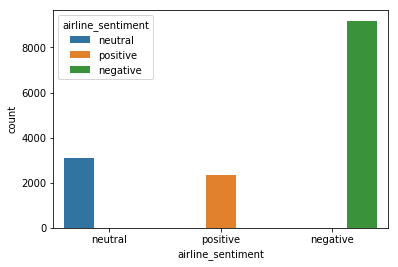

In [9]:
sns.countplot(x=df['airline_sentiment'],hue=df['airline_sentiment'])
print(df['airline_sentiment'].value_counts(normalize=True))

Around 62% tweets are negitive, 21% neutral and 16% positive.

Let's see the top words appearing in positive,negitive and neutral sentiments

In [10]:
#For positive class
from collections import Counter
top_n = 10
Counter(" ".join(df[df['airline_sentiment']=='positive'].text).split()).most_common(top_n)

[('the', 924),
 ('to', 923),
 ('for', 658),
 ('I', 574),
 ('@SouthwestAir', 548),
 ('you', 509),
 ('@JetBlue', 503),
 ('a', 501),
 ('@united', 472),
 ('and', 416)]

In [11]:
#For negitive class
Counter(" ".join(df[df['airline_sentiment']=='negative'].text).split()).most_common(top_n)

[('to', 5966),
 ('the', 3929),
 ('I', 3375),
 ('a', 3087),
 ('and', 2685),
 ('for', 2665),
 ('on', 2593),
 ('@united', 2510),
 ('my', 2225),
 ('@USAirways', 2207)]

In [12]:
#For neutral class
Counter(" ".join(df[df['airline_sentiment']=='neutral'].text).split()).most_common(top_n)

[('to', 1646),
 ('I', 1105),
 ('the', 928),
 ('a', 771),
 ('@united', 657),
 ('@SouthwestAir', 639),
 ('you', 631),
 ('on', 631),
 ('for', 598),
 ('@JetBlue', 578)]

As we can see particular airlinee company comes quite a lot in top words, this may be because in tweets we tag to reply to someone.

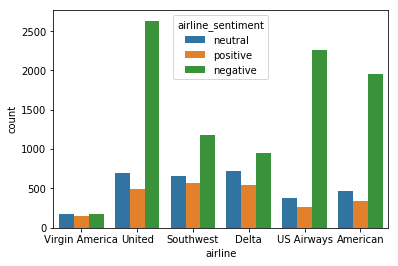

In [13]:
sns.countplot(x='airline', hue='airline_sentiment', data=tweet)

Negative sentiments are quite a lot for united airline, so if **united** is present then model may learn to associate it with negitive class, besides that in tops words of all classes contain some name of airline so we can remove those tag words.

##### Removing airline tags

In [14]:
airlines = tweet['airline'].unique()
airlines

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American'], dtype=object)

In [15]:
import re
pattern = r'@[\w]+'
func = lambda x:re.sub(pattern, '', x)
df['text'] = df['text'].apply(func)
df.sample(5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,airline_sentiment,text
2610,negative,"sure, but 8 different texts changing time &am..."
1975,negative,", fuck you and your closed premier access line..."
6655,neutral,any idea on flights to Nashville tomorrow bei...
7606,negative,hmmm it says im following you. We just got d...
12155,negative,this delayed bag was for my friend Lisa Pafe....


## Model Building

In [31]:
#path = Path.resolve('../input').resolve()
#train_valid, test = train_test_split(df, test_size=0.25)
train, valid = train_test_split(train_valid, test_size=0.25)
data_lm = TextLMDataBunch.from_df('./', train, valid)

moms = (0.8,0.7)
wd = 0.1

In [32]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 5.25E-02


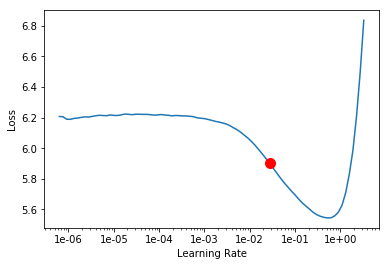

In [33]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [34]:
learn.fit_one_cycle(1, 2.75E-02, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,4.532598,4.016943,0.260530,00:05


In [36]:
learn.unfreeze()
learn.fit_one_cycle(5, 2.75E-02, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,2.436494,4.096618,0.266360,00:06
1,3.157795,4.014274,0.270194,00:06
2,3.308105,3.955526,0.277902,00:06
3,2.979815,3.968257,0.283154,00:06
4,2.377139,4.108468,0.283009,00:06


In [37]:
learn.predict('It was a decent experience', n_words=10
             )

'It was a decent experience . The airline i checked and more mechanical problems'

In [38]:
learn.predict('Service was not that great', n_words=10)

'Service was not that great . i really needed to be in their coming up'

In [39]:
learn.save_encoder('encoder.pth')

### Building the classifer

In [40]:
classifier = TextClasDataBunch.from_df('./', train, valid, test_df=test, vocab=data_lm.train_ds.vocab,
                                          label_cols='airline_sentiment', text_cols='text')
classifier.show_batch()

text,target
xxbos xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos xxmaj many xxmaj thanks for the xxmaj follow . \n # ourprincess # freyasfund # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 🌏 🎀 http : / / t.co / xxunk,neutral
"xxbos . ( 2 / 3 ) ... i sat on the runway for 4 xxup more xxup hrs b4 takeoff ( 10 hrs xxmaj late xxmaj flight , xxunk xxup am ) . xxmaj pilot xxunk stated it was a comp / mech issue .",negative
xxbos - xxmaj kids left a kindle fire xxup hd 6 onboard xxup xxunk ( xxup ord - xxup sfo ) today . xxmaj row xxup xxunk - xxup def ( we had the whole row amongst the 5 of us ) . xxmaj help ...,neutral
xxbos xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 3.02E-02


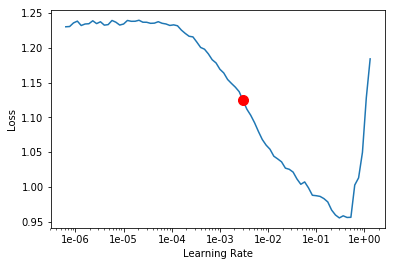

In [48]:
learn = text_classifier_learner(classifier, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('encoder.pth')
learn.freeze()

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [49]:
learn.fit_one_cycle(1, 3.02E-03, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.656665,0.554371,0.786885,00:04


In [50]:
learn.freeze_to(-2)
lr = 3.63E-03 / 5
learn.fit_one_cycle(1, slice(lr/2**4, lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.597273,0.515586,0.791385,00:05


In [51]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.550997,0.520332,0.795886,00:07


In [52]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(10, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.530860,0.515520,0.795564,00:08
1,0.557160,0.509368,0.794921,00:08
2,0.535292,0.511815,0.800707,00:09
3,0.532899,0.505710,0.797493,00:09
4,0.515436,0.508615,0.794921,00:08
5,0.502828,0.509206,0.795243,00:08
6,0.505467,0.507768,0.798457,00:09
7,0.500118,0.507111,0.800064,00:08
8,0.496619,0.506973,0.801350,00:09
9,0.487969,0.509526,0.800707,00:09


In [53]:
learn.fit_one_cycle(5, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.498110,0.529251,0.799100,00:09
1,0.484991,0.515293,0.800064,00:09
2,0.482616,0.510545,0.800064,00:09
3,0.461524,0.512935,0.798457,00:09
4,0.468760,0.511898,0.801993,00:08


In [54]:
learn.predict('Great flight')

(Category positive, tensor(2), tensor([0.0062, 0.0219, 0.9718]))

In [55]:
learn.predict('staff behaviour was good')

(Category positive, tensor(2), tensor([0.2949, 0.0959, 0.6092]))

In [56]:
learn.predict('service was good but flight got delayed')

(Category negative, tensor(0), tensor([0.8135, 0.0698, 0.1167]))

### Accuracy

In [57]:
interp = TextClassificationInterpretation.from_learner(learn)
acc = accuracy(interp.preds, interp.y_true)
print('Accuracy: {0:.3f}'.format(acc))

Accuracy: 0.802


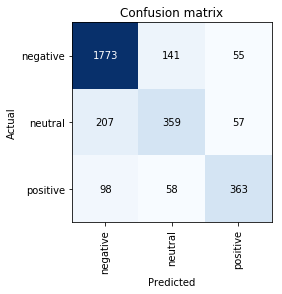

In [58]:
interp.plot_confusion_matrix()

In [ ]:
learn.save('model.pth')